This is the tutorial for the evaluation of CPHF alchemical derivatives using PySCF (version 2.2)

In [1]:
from pyscf import gto,scf
import numpy as np
import pyscf
import matplotlib.pyplot as plt
import basis_set_exchange as bse

pyscf.__version__

'2.2.0'

## Fractional charge molecules

In [2]:
from FcMole import FcM, FcM_like

In [3]:
mol_NN=gto.M(atom= "N 0 0 0; N 0 0 2.1",unit="Bohr", basis="sto-3g") 

The FcM_like function creates a copy of a givem PySCF molecule object with modified nuclear cherges 

In [4]:
fmol1=FcM_like(mol_NN,fcs=[.1,-.1])

Only nuclear charges are modified, the number of electrons stays the same

In [5]:
fmol1.atom_charges(),fmol1.nelec

(array([7.1, 6.9]), (7, 7))

The same result can be achieved using the FcM constructor

In [6]:
fmol2=FcM(fcs=[.2,-.2],atom= "N 0 0 0; N 0 0 2.1",unit="Bohr", basis="sto-3g")

The number of electron matches the atom string

In [7]:
fmol2.atom_charges(),fmol2.nelec

(array([7.2, 6.8]), (7, 7))

If only some atoms have modified nuclear charges is possible to pass as a fcs parameter a double list [[idxs],[fcs]]

In [8]:
fmol3=FcM(fcs=[[0,1],[.3,-.3]],atom= "N 0 0 0; N 0 0 2.1",unit="Bohr", basis="sto-3g")

In [9]:
fmol3.atom_charges(),fmol3.nelec

(array([7.3, 6.7]), (7, 7))

For scf calculations using fractional charges molecules the initial density matrix guess needs to be evaluated from the eigenfunction of the monoelectronic Hamiltonian (there is no single atom density "SAD" matrix guess for atoms with fractional charge)

In [10]:
mf=scf.RHF(mol_NN)
mf1=scf.RHF(fmol1)
mf2=scf.RHF(fmol2)
mf3=scf.RHF(fmol3)

In [11]:
e=mf.scf(dm0=mf.init_guess_by_1e())
e1=mf1.scf(dm0=mf1.init_guess_by_1e())
e2=mf2.scf(dm0=mf2.init_guess_by_1e())
e3=mf3.scf(dm0=mf3.init_guess_by_1e())

converged SCF energy = -106.786312173968
converged SCF energy = -106.801217627227
converged SCF energy = -106.846028831322
converged SCF energy = -106.921050773896


/home/giorgio/anaconda3/lib/python3.8/site-packages/pyscf/gto/mole.py:1209: UserWarning: Function mol.dumps drops attribute with_rinv_at_nucleus because it is not JSON-serializable
  warnings.warn(msg)


for small basis sets the scf does not converge to the true minimum -> using initial guess from previous step enforces it 


In [12]:
mf1.scf(dm0=mf.make_rdm1())
mf2.scf(dm0=mf1.make_rdm1())
mf3.scf(dm0=mf2.make_rdm1())

converged SCF energy = -106.80121762985
converged SCF energy = -106.846028831319
converged SCF energy = -106.921050773896


-106.92105077389597

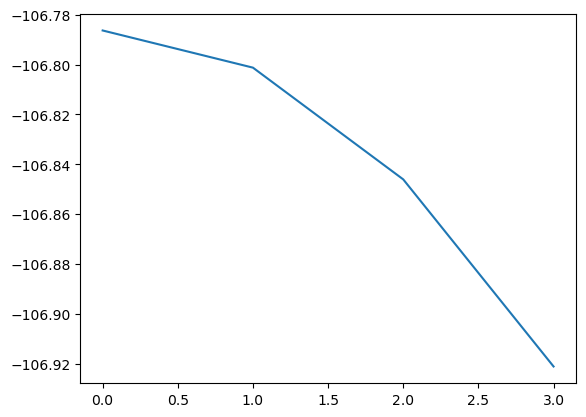

In [13]:
plt.plot([e,e1,e2,e3]) # the potential 

## Using the Alchemical Perturbator (AP) class
We created an Alchemical perturbator object to access easily all the CPHF methods for alchemical derivative and alchemical forces derivatives, this allow us to save the derivatives and also to exploit the symmetry of the system

In [14]:
%load_ext autoreload
%autoreload 2
from AP_class import APDFT_perturbator as AP

In [15]:
mol_NN_pcX2=gto.M(atom= "N 0 0 0; N 0 0 2.1",unit="Bohr",basis=bse.get_basis('pcX-2',fmt="nwchem",elements=[6,7,8]))

The alchemical perturbator is instantiated from a converged RHF object, and for some given perturbation sites.

In [16]:
mf_nn=scf.RHF(mol_NN_pcX2)
mf_nn.scf()
ap_nn=AP(mf_nn,sites=[0,1])

converged SCF energy = -108.982443290901


Alchemical gradient $ \partial E/\partial Z_i $, hessian $\partial^2E/\partial Z_i\partial Z_j$ and cubic hessian $\partial^3E/\partial Z_i\partial Z_j\partial Z_k$can be obtained from their buid functions 


In [17]:
#build the alchemical gradient dE/dZ_i
ap_nn.build_gradient()

array([-18.26852542, -18.26852542])

In [18]:
#build the alchemical hessian d**2E/dZ_i/dZ_j
ap_nn.build_hessian()

array([[-3.30790482,  0.49616476],
       [ 0.49616476, -3.30790482]])

In [19]:
ap_nn.build_cubic_hessian()

array([[[-0.26999069,  0.12075961],
        [ 0.12075961,  0.12075961]],

       [[ 0.12075961,  0.12075961],
        [ 0.12075961, -0.26999069]]])

Are saved inside the class and can be accessed in a later moment

In [20]:
ap_nn.gradient,ap_nn.hessian,ap_nn.cubic_hessian

(array([-18.26852542, -18.26852542]),
 array([[-3.30790482,  0.49616476],
        [ 0.49616476, -3.30790482]]),
 array([[[-0.26999069,  0.12075961],
         [ 0.12075961,  0.12075961]],
 
        [[ 0.12075961,  0.12075961],
         [ 0.12075961, -0.26999069]]]))

Alchemical perturbations for isolelectronic transmutations can be calculated from the derivatives up to order 3

In [21]:
ap_nn.APDFT1(np.asarray([-1,0])) # to CN-

-90.71391786926834

In [22]:
ap_nn.APDFT2(np.asarray([-1,1])) # to CO

-112.78651287823459

In [23]:
ap_nn.APDFT3(np.asarray([0,1]))  # to NO+

-128.9499195733697

In [24]:
ap_nn.APDFT3(np.asarray([1,1])) # to OO++

-148.30047148493995

## Alchemical forces
Alchemical forces are calculated resusing the density matrix derivatives already evaluated. The function af(I) gives the alchemical force of the atom $I$ : $\partial \mathbf{g}/ \partial Z_I$ [2]


In [25]:
ap_nn.af(0),ap_nn.af(1)

(array([[-6.76360348e-14, -5.47441960e-14, -2.15590754e-01],
        [ 6.76360348e-14,  5.47441960e-14,  2.15590754e-01]]),
 array([[-2.63911236e-15, -6.68298947e-14, -2.15590754e-01],
        [ 2.63911236e-15,  6.68298947e-14,  2.15590754e-01]]))

## Basis set effects 
The class also include methods to calculate the energy of the target molecules, with its basis set and with the basis set of the reference,

In [31]:
ap_nn.target_energy([0,-1]),ap_nn.target_energy_ref_bs([0,-1])

converged SCF energy = -128.950505504676
converged SCF energy = -128.950528571069


(-128.95050550467604, -128.9505285710693)

To double check for CN- 

In [33]:
scf.RHF(gto.M(atom= "N 0 0 0; C 0 0 2.1",unit="Bohr",
       basis=bse.get_basis('pcX-2',fmt="nwchem",elements=[6,7,8]),charge=-1)).scf()

converged SCF energy = -128.950505504676


-128.95050550467627

The APDFT3 predictions approximate the energy of the molecule with the reference basis set 

In [28]:
ap_nn.APDFT3([0,-1])

-92.32287183327608

But we can correct it using the single atom basis set correction [1]

In [29]:
ap_nn.APDFT3([0,-1])+ap_nn.ap_bsec([0,-1])

-92.32700488049362

## References 

[1] Giorgio Domenichini, Guido Falk von Rudorff, and O. Anatole von Lilienfeld : "Effects of perturbation order and basis set on alchemical predictions", J. Chem. Phys. 153, 144118 (2020)

[2] Giorgio Domenichini, and O. Anatole von Lilienfeld: "Alchemical predictions of relaxed geometries throughout chemical space", under review (2021) 